In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [301]:
from datetime import date
import time
today = date.today()
print(today)

2021-04-20


In [308]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
driver = webdriver.Chrome('C:/Users/seant/OneDrive/Desktop/chromedriver_win32/chromedriver.exe')
driver.get('https://www.nasdaq.com/market-activity/stocks/amzn/advanced-charting/')

In [309]:
graph_frame = driver.find_element_by_xpath('//*[@id="chartholder"]/iframe')
driver.switch_to.frame(graph_frame)

In [310]:
period_button = driver.find_element_by_id('periodBtn')
ActionChains(driver).move_to_element(period_button).click().perform()

In [311]:
min_period = driver.find_element_by_xpath('//*[@id="periodicity"]/li[5]')
ActionChains(driver).move_to_element(min_period).click().perform()

In [312]:
table_button = driver.find_element_by_id("dataTableBtn")
table_button.click()

In [313]:
driver.switch_to.default_content()

In [314]:
table_frame = driver.find_element_by_xpath('//*[@id="chartholder"]/iframe')
driver.switch_to.frame(table_frame)

In [315]:
wait = WebDriverWait(driver, 10)
export_to_excel_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@onclick="window.grid.exportToExcel()"]')))
ActionChains(driver).move_to_element(export_to_excel_button).click().perform()

In [316]:
driver.quit()

In [320]:
import shutil
old_excel_dir = 'C:/Users/seant/Downloads/grid.xls'
today_data = f'data/AMZN_{today}.xls'
new_dir = f'C:/Users/seant/stock_analyzer/{today_data}'

In [318]:
shutil.move(old_excel_dir, new_name);

In [ ]:
import requests
AMZN_nasdaq_url = 'https://www.nasdaq.com/market-activity/stocks/amzn/advanced-charting'
r = requests.get(AMZN_nasdaq_url, allow_redirects=True)

In [347]:
today_table = pd.read_excel(today_data)

In [348]:
today_table.head()

,Date,Open,High,Low,Close,Volume
0,2021-04-20 09-30,3381.1899,3381.1899,3381.1899,3381.1899,75810.0
1,2021-04-20 09-31,3378.5071,3378.5071,3378.5071,3378.5071,10231.0
2,2021-04-20 09-32,3371.9951,3371.9951,3371.9951,3371.9951,13464.0
3,2021-04-20 09-33,3365.0000,3365.0000,3365.0000,3365.0000,12944.0
4,2021-04-20 09-34,3367.0300,3367.0300,3367.0300,3367.0300,5996.0


In [349]:
date_array = today_table.loc[:, 'Date']

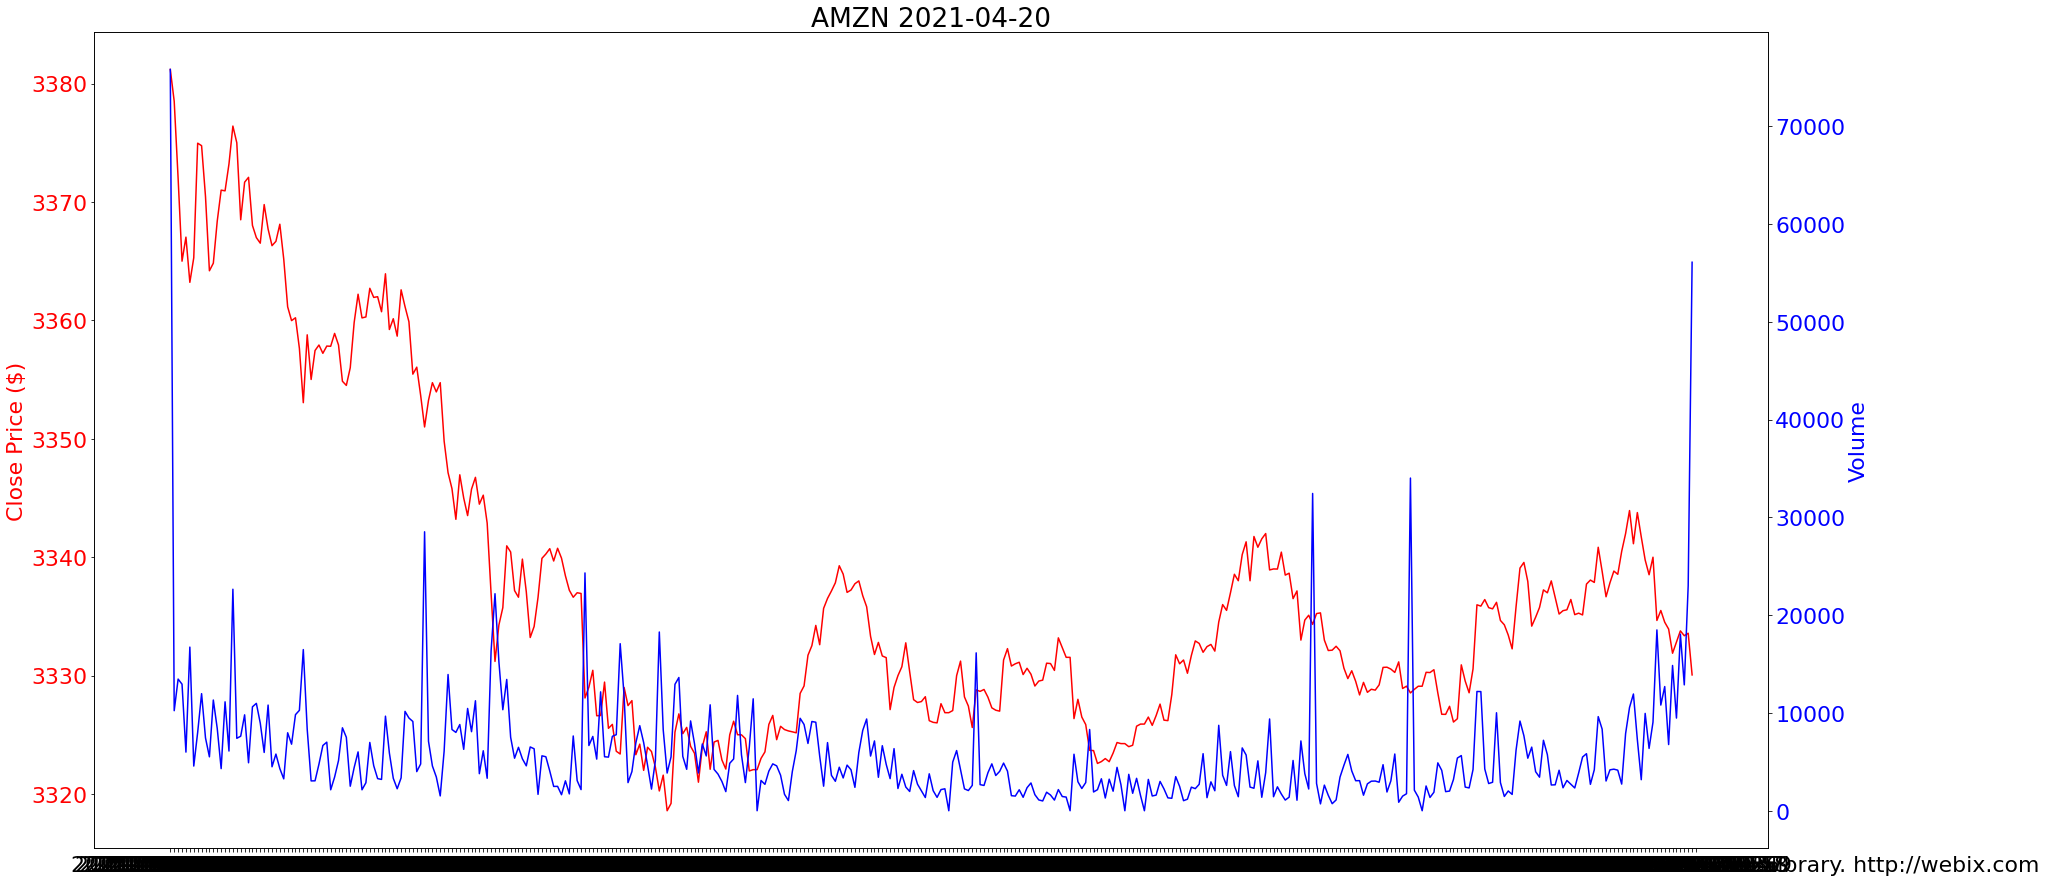

In [356]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.plot(date_array, today_table.loc[:, 'Close'], color='r', label='Close')
ax1.set_ylabel('Close Price ($)', color ='r')
ax1.set_title(f'AMZN {today}')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(date_array, today_table.loc[:, 'Volume'], color='b', label='Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.show()